In [1]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import ElementClickInterceptedException, TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import pickle
from pysentiment2.lm import LM
import matplotlib.pyplot as plt
from datetime import datetime
from wordcloud import WordCloud

In [2]:
FED_BASE_URL = "https://www.federalreserve.gov"
FED_SPEECHES_URL = "https://www.federalreserve.gov/newsevents/speeches.htm"

In [3]:
print("Instantiating Chrome web driver")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

Instantiating Chrome web driver


In [4]:
def get_fed_speeches(start_date, end_date):
    START_DATE_XPATH = "//*[@id=\"content\"]/div[2]/div/div[1]/form/div[2]/div/div[1]/input"
    END_DATE_XPATH = "//*[@id=\"content\"]/div[2]/div/div[1]/form/div[2]/div/div[2]/input"
    SUBMIT_BUTTON_XPATH = "//*[@id=\"content\"]/div[2]/div/div[1]/form/div[5]/a"
    driver.get(FED_SPEECHES_URL)
    start_date_input_box = driver.find_element("xpath", START_DATE_XPATH)
    end_date_input_box = driver.find_element("xpath", END_DATE_XPATH)
    start_date_input_box.clear()
    start_date_input_box.send_keys(start_date)
    end_date_input_box.clear()
    end_date_input_box.send_keys(end_date)
    submit_button = driver.find_element("xpath", SUBMIT_BUTTON_XPATH)
    submit_button.click()
    return

In [5]:
def get_next_page():
    NEXT_BUTTON_TEXT = "Next"
    try:
        element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.LINK_TEXT, NEXT_BUTTON_TEXT))
        )
    except TimeoutException:
        return False

    next_button = driver.find_element("link text", NEXT_BUTTON_TEXT)

    if next_button.get_attribute("disabled") is None:
        next_button.click()
        return True

    return False

In [6]:
def get_fed_speech_links(all_speeches):
    soup = BeautifulSoup(all_speeches, 'html.parser')
    fed_page_links = soup.find_all("a", href=True)
    fed_speech_transcript_links = [link['href'] for \
            link in fed_page_links if "/speech/" in link['href']]
    return fed_speech_transcript_links

In [7]:
import re

def get_fed_speech_transcript_links(fed_speech_links):
    DATE_LENGTH = 8
    fed_speech_transcript_links = []
    for link in fed_speech_links:
        date = re.findall('[0-9]+', link)
        if len(date) != 0:
            date = date[0]
        if len(date) == DATE_LENGTH:
            fed_speech_transcript_links.append(link)
    return fed_speech_transcript_links

In [8]:
def filter_duplicate_links(fed_speech_links):
    uniq_links = set(fed_speech_links)
    return list(uniq_links)

In [9]:
def get_fed_speeches_body(fed_speech_links):
    all_fed_speeches = []
    for link in fed_speech_links:
        all_fed_speeches.append(requests.get(FED_BASE_URL + link).text)
    return all_fed_speeches

In [10]:
def get_speech(fed_speech_links, fed_speeches_source):
    fed_speech_content = {}
    num_speeches = len(fed_speech_links)
    for speech_idx in range(num_speeches):
        date = re.findall('[0-9]+', fed_speech_links[speech_idx])[0]
        soup = BeautifulSoup(fed_speeches_source[speech_idx], "html.parser")
        speech_text = ""
        for paragraph in soup.find_all('p'):
            speech_text += paragraph.get_text()
        speech_link = fed_speech_links[speech_idx].replace("/newsevents/speech/", "").replace(".htm", "")
        fed_speech_content[speech_link] = (date, speech_text)
    return fed_speech_content

In [11]:
def tokenize_corpus(filing_corpus):
    filing_tokenizer = RegexpTokenizer(r'\w+')
    return filing_tokenizer.tokenize(filing_corpus)

# a function to remove the stop words from corpus
def filter_out_stopwords(tokenized_corpus):
    stop_words = set(stopwords.words('english'))
    filing_corpus_filtered = [word for word in tokenized_corpus if not \
        word.lower() in stop_words]
    return filing_corpus_filtered


# a function that filters out numbers from corpus
def filter_out_numbers(tokenized_corpus):
    return [token for token in tokenized_corpus if not (token.isdigit()
                                         or token[0] == '-' and token[1:].isdigit())]

In [12]:
def tokenize_fed_speeches(fed_speeches_dict):
    tokenized_speeches = {}
    DATE_IDX = 0
    CONTENT_IDX = 1
    for link, speech in fed_speeches_dict.items():
        tokenized_corpus = tokenize_corpus(speech[CONTENT_IDX])
        tokenized_corpus = filter_out_stopwords(tokenized_corpus)
        tokenized_corpus = filter_out_numbers(tokenized_corpus)
        speech_link = link.replace("/newsevents/speech/", "").replace(".htm",
                                                                      "")
        tokenized_speeches[speech_link] = (speech[DATE_IDX], tokenized_corpus)
    return tokenized_speeches

In [13]:
SPEECHES_DIR = "fed_speeches/"

def write_to_disc(file_names, file_content):
    for file_idx in range(len(file_names)):
        file_name = file_names[file_idx].replace('/', '_')
        file_name = file_name.replace(".htm", "").replace("_newsevents_speech_", "")
        with open(SPEECHES_DIR + file_name + ".txt", 'w') as f:
            f.write(file_content[file_idx])

In [14]:
SERIALIZATION_DIR = "serialized_data/"

def serialize_speeches(speeches_dict):
    with open(SERIALIZATION_DIR + "speeches_dict.pkl", "wb") as f:
        pickle.dump(speeches_dict, f)

In [15]:
def load_speeches(picked_file_name):
    with open(SERIALIZATION_DIR + picked_file_name, "rb") as f:
        dict = pickle.load(f)
    return dict

In [16]:
print("Retrieving all links from the fed speeches web page ")

START_DATE = "05/01/2022"
END_DATE = "11/01/2022"

count = 1
fed_page_links = []
get_fed_speeches(START_DATE, END_DATE)
fed_page_links.extend(get_fed_speech_links(driver.page_source))
while get_next_page():
    fed_page_links.extend(get_fed_speech_links(driver.page_source))
    print("Processed page number: ", count)
    count += 1

Retrieving all links from the fed speeches web page 
Processed page number:  1


In [17]:
print("Retrieving all speech transcripts from the fed web page ")
fed_page_transcript_links = get_fed_speech_transcript_links(fed_page_links)

Retrieving all speech transcripts from the fed web page 


In [18]:
print("Filtering out duplicate links ")
speech_links = filter_duplicate_links(fed_page_transcript_links)

Filtering out duplicate links 


In [19]:
print("Getting the body of all fed speeches")
fed_speeches_body = get_fed_speeches_body(speech_links)

Getting the body of all fed speeches


In [20]:
print("Parsing the speech body for each speech")
speeches_text = get_speech(speech_links, fed_speeches_body)

Parsing the speech body for each speech


In [21]:
WRITE_SPEECHES_TO_DISC = False
if WRITE_SPEECHES_TO_DISC:
    print("Writing crawled speeches to disk")
    speeches_body_list = [speech[1] for speech in list(speeches_text.values())]
    write_to_disc(speech_links, speeches_body_list)

In [22]:
print("Tokenizing the body of each speech")
tokenized_speeches = tokenize_fed_speeches(speeches_text)

Tokenizing the body of each speech


In [23]:
SERIALIZE_SPEECHES = False
if SERIALIZE_SPEECHES:
    print("Serializing tokenized speeches")
    serialize_speeches(tokenized_speeches)

In [24]:
print("The number of speeches processed is ", len(tokenized_speeches))

The number of speeches processed is  31


In [25]:
def get_sentiment_score(speeches_dict):

    DATE_IDX = 0
    SPEECH_IDX = 1
    speech_dates = []
    speech_sentiments = []

    # get the Loughran and McDonald dictionary
    lm = LM()

    for speaker, speech in speeches_dict.items():
        DATE_FORMAT="%Y%m%d"
        speech_date = speech[DATE_IDX]
        datetime_date = datetime.strptime(speech_date, DATE_FORMAT)
        speech_dates.append(datetime_date)
        speech_sentiments.append(lm.get_score(speech[SPEECH_IDX])['Negative'])

    return speech_dates, speech_sentiments

In [26]:
speech_dates, speech_sentiments = get_sentiment_score(tokenized_speeches)

Plotting the result


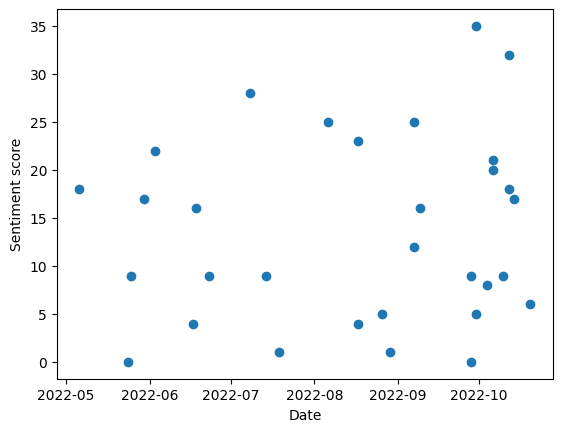

In [27]:
print("Plotting the result")

plt.scatter(speech_dates, speech_sentiments)
plt.xlabel("Date")
plt.ylabel("Sentiment score")
plt.show()

Plotting the same result on a bar graph


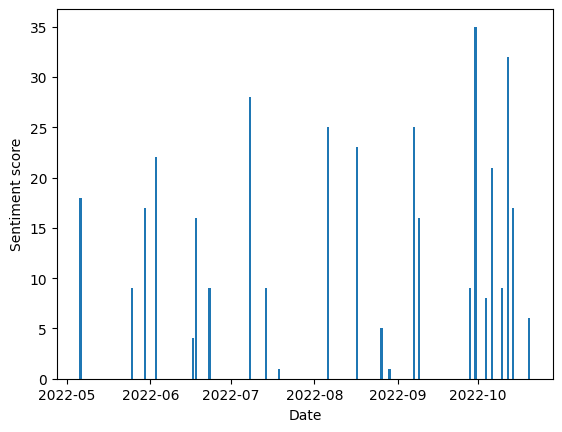

In [28]:
print("Plotting the same result on a bar graph")

plt.bar(speech_dates, speech_sentiments, linewidth=10.0)
plt.xlabel("Date")
plt.ylabel("Sentiment score")
plt.show()

In [29]:
def get_speech_text_for_a_time_period(speech_dict, since_date):

    DATE_FORMAT="%Y%m%d"
    since_date = datetime.strptime(since_date, DATE_FORMAT)

    speech_texts = []
    DATE_IDX = 0
    SPEECH_IDX = 1

    for speaker, speech in speech_dict.items():
        speech_date = speech[DATE_IDX]
        datetime_date = datetime.strptime(speech_date, DATE_FORMAT)
        if datetime_date > since_date:
            speech_texts.extend(speech[SPEECH_IDX])

    return ' '.join(speech_texts)

Plotting speech wordcloud for the past 3 month


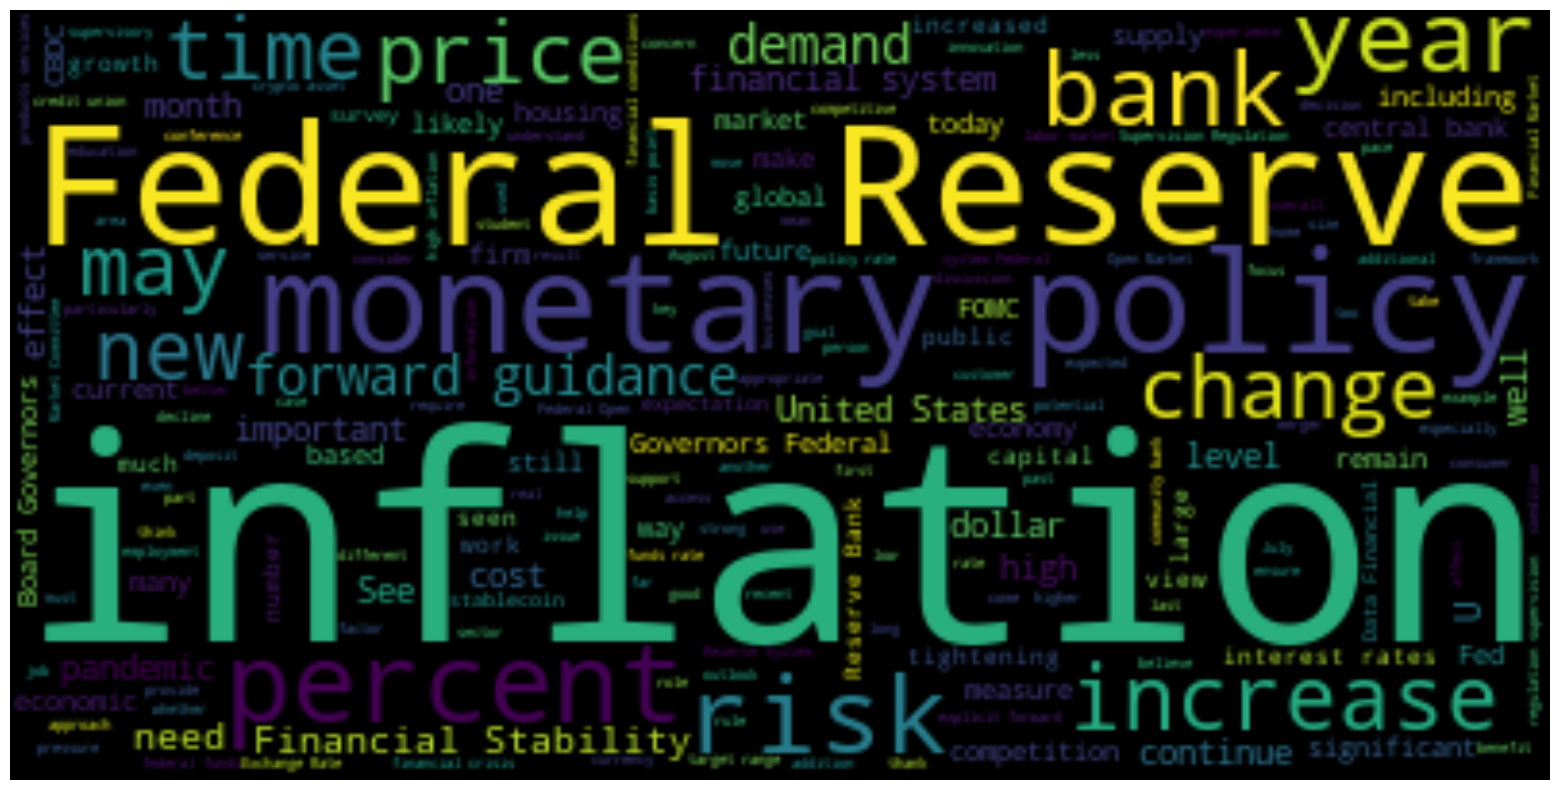

In [30]:
print("Plotting speech wordcloud for the past 3 month")

speech_texts = get_speech_text_for_a_time_period(tokenized_speeches, "20220901")

speech_word_cloud = WordCloud(random_state=21,
                           max_font_size=119).generate(speech_texts)

plt.figure(figsize=(20,10))
plt.imshow(speech_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<h1>Analysis of the results above<h1>

In this work, we've analyzed a sample of FED speeches for the past 6 month.

By running sentiment analysis on the speeches using Loughran
McDonald financial dictionary, we have discovered that the sentiment of FED
speeches started leaning towards negative in the past 3 month, as
compared to the overall body of speeches.

We've illustrated such a pattern using both scatter plot and a bar graph.

Upon further investigation, we've used a World Cloud visualization to
identify the most frequently used words on FED speeches.

We can clearly see that the word **Inflation** is the most frequently used word
 in the past 3 month during FED speeches, along with the word **increase**
 and **risk**.

From these results, we can conclude that the FED tone has shifted **from Dovish
 to Hawkish** in the past months, with FED focusing its efforts on taming rising
 inflation as opposed to the economic growth.